# Overview Analysis 


In [ ]:
# Import libraries 
import pandas as pd
import numpy as np
import json
import os

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import plotly.express as px
import geopandas as gpd
import geoplot as gplt 
import geoplot.crs as gcrs
import warnings
import zipfile

current_wd=os.getcwd()


In [ ]:
# Load US Geo data
with open(f"{current_wd}/data/raw/us-states.json", encoding='utf8') as code:
    usa_states = json.load(code)


# Load car accidents data
df = pd.read_csv(f'{current_wd}/data/processed_us_car_accidents_2022.csv')
df.head()

,ID,Source,Severity,Start_Time,End_Time,Start_Lattitude,Start_Longitude,End_Lattitude,End_Longitude,Distance(mi),...,Pressure(in),Visibility(mi),Wind_Direction,Wind_Speed(mph),Precipitation(in),Weather_Condition,Traffic_Signal,Sunrise_Sunset,State_Abbrv,Population
0,A-512230,Source2,1,2022-09-08 05:49:30,2022-09-08 06:34:53,41.946796,-88.208092,41.946796,-88.208092,0.00,...,29.24,10.0,CALM,0.0,0.0,Fair,True,Night,IL,12582032
1,A-512231,Source2,1,2022-09-08 02:02:05,2022-09-08 04:31:32,34.521172,-117.958076,34.521172,-117.958076,0.00,...,27.35,10.0,W,6.0,0.0,Fair,False,Night,CA,39029342
2,A-512232,Source2,1,2022-09-08 05:14:12,2022-09-08 07:38:17,37.542839,-77.441780,37.542839,-77.441780,0.00,...,29.71,10.0,N,8.0,0.0,Mostly Cloudy,True,Night,VA,8683619
3,A-512233,Source2,1,2022-09-08 06:22:57,2022-09-08 06:52:42,40.896629,-81.178452,40.896629,-81.178452,0.00,...,28.71,7.0,NNE,6.0,0.0,Mostly Cloudy,False,Night,OH,11756058
4,A-512234,Source2,2,2022-09-08 06:36:20,2022-09-08 07:05:58,41.409359,-81.644318,41.409359,-81.644318,1.91,...,29.37,7.0,SSE,3.0,0.0,Partly Cloudy,False,Night,OH,11756058


/Users/tranghoang/opt/anaconda3/lib/python3.9/site-packages/matplotlib/text.py:757: FutureWarning:

Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead

/Users/tranghoang/opt/anaconda3/lib/python3.9/site-packages/matplotlib/text.py:758: FutureWarning:

Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead

/Users/tranghoang/opt/anaconda3/lib/python3.9/site-packages/matplotlib/text.py:897: FutureWarning:

Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead

/Users/tranghoang/opt/anaconda3/lib/python3.9/site-packages/matplotlib/text.py:898: FutureWarning:

Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead



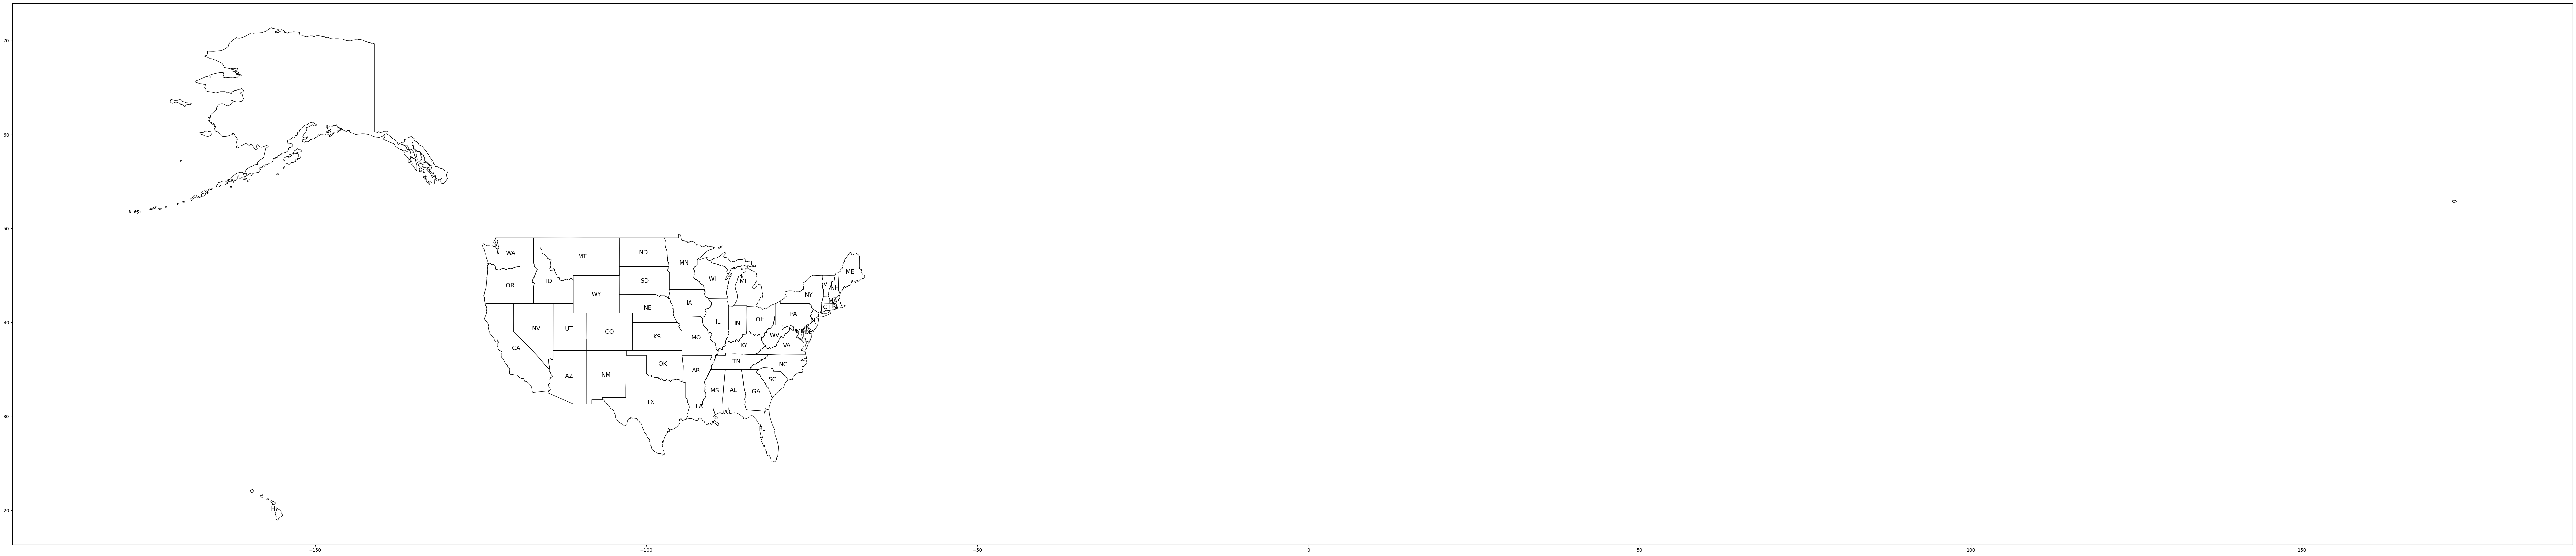

In [ ]:
# Code O

# Step 1: Read the GeoJSON Data
geojson_path = f'{current_wd}/data/raw/us-states.json'
us_states_gdf = gpd.read_file(geojson_path)

# Create a plot
ax = us_states_gdf.plot(figsize=(100, 100), edgecolor='k', facecolor='none')

state_abbr=[]
x_coor=[]
y_coor=[]
for feature in usa_states['features']:
    state_name = feature['properties']['name']
    state_abbr.append(feature['id'])# Assuming the abbreviation is in the GeoJSON properties
    centroid = gpd.GeoDataFrame.from_features([feature]).geometry.centroid
    x_coor.append(centroid.geometry.x)
    y_coor.append(centroid.geometry.y)

# Remove AK 
ak_index = state_abbr.index('AK')
state_abbr.pop(ak_index)
x_coor.pop(ak_index)
y_coor.pop(ak_index)

# Add labels to the plot
for x, y, label in zip(x_coor, y_coor, state_abbr):
    ax.text(x, y, label, fontsize=13, ha='center', va='center')


In [ ]:
df[['ID','State','Population']].head(10)

,ID,State,Population
0,A-512230,IL,12582032
1,A-512231,CA,39029342
2,A-512232,VA,8683619
3,A-512233,OH,11756058
4,A-512234,OH,11756058
5,A-512235,PA,12972008
6,A-512236,OH,11756058
7,A-512237,OH,11756058
8,A-512238,SC,5282634
9,A-512239,SC,5282634


In [ ]:
# Generate the data for figures
# Count number of accidents 
accident_counts = df['State'].value_counts().reset_index()
accident_counts.columns = ['State', 'Counts']

# Extract population per state (assuming the population is the same for each state entry)
population_data = df[['State', 'Population']].drop_duplicates()

# Merge the counts with the population data
accidents_per_capita = accident_counts.merge(population_data, on='State')


# Calculate accidents per capita
accidents_per_capita['Accidents Per Capita'] = accidents_per_capita['Counts'] / accidents_per_capita['Population']

In [ ]:
accidents_per_capita.head()

,State,Counts,Population,Accidents Per Capita
0,CA,374269,39029342,0.009589
1,FL,262225,22244823,0.011788
2,VA,99015,8683619,0.011403
3,TX,95084,30029572,0.003166
4,NY,94258,19677151,0.004790


In [ ]:
# Creating the choropleth map using Plotly Express
fig = px.choropleth(
    data_frame=accidents_per_capita,  # Data containing the number of accidents
    geojson=usa_states,  # GeoJSON data for USA states
    color='Accidents Per Capita',  # Column representing the number of accidents
    locations='State',  # Column with state names or codes
    color_continuous_scale="Reds",  # Color scale for the choropleth map
    scope="usa",  # Focus the map on the USA
    labels={'Accidents Per Capita'}  # Label for the color bar
)

# Update the layout for better presentation
fig.update_geos(
    fitbounds="locations",  # Fit the geographical elements within the view
    visible=False  # Hide geographical elements borders
)
fig.update_layout(
    margin={"r":0, "t":40, "l":0, "b":0},  # Adjust margins to fit title
    title_text='Number of Car Accidents Per Capita by States in 2022',  # Adding a title
    title_x=0.5,  # Centering the title
    title_font=dict(size=20),  # Adjusting the font size of the title
    title_y=0.98,  # Adjusting the position of the title
    geo=dict(
        showland=True, 
        landcolor="white"
    )
)



**Observation**
- South Carolina(SC) has the highes number of accidents per capita: it stands out with the darkest shade, indicating it has the highest number of car accidents, approaching about 0.0159 number of accidents per cappita

- Majority of high ratio numbers located in the middle east to south east side (e.g Virgina and Florid) and west/north west side (eg Montana). These regions have ratio about 0.006 to about 0.01

- Lower accident density is in the the middle of the US: The middle part of the US to South exhibits much lighter shade. This indicates a lower number of car accidents. The ratio is about 0.005 and lower

## Top 5 States that have the highest number of car accidents per Capita

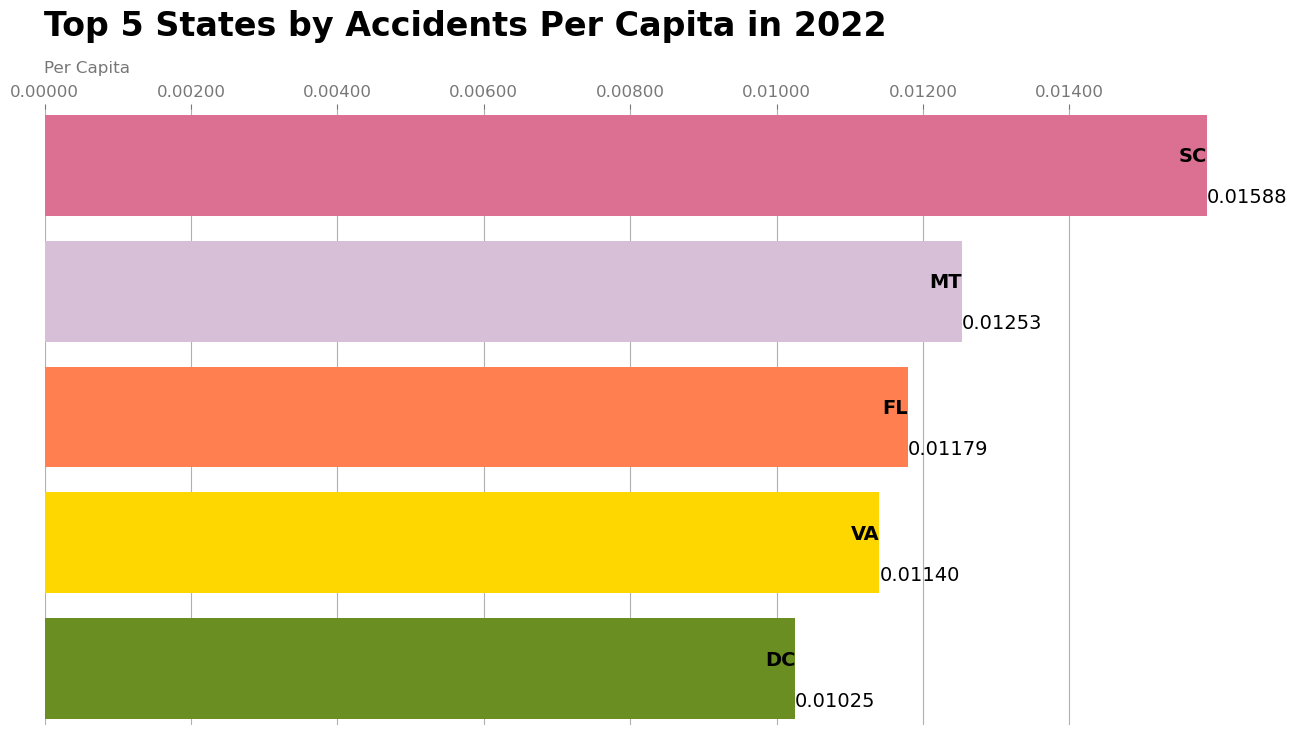

In [ ]:
# Find top 5 states that has highest accidents per capita

top_accidents_per_capita = accidents_per_capita.sort_values('Accidents Per Capita', ascending = False)[:5]
top_accidents_per_capita = top_accidents_per_capita[::-1]   # flip values from top to bottom
top_accidents_per_capita


# Create visualizations
# Define colors for the bars
colors = ['olivedrab', 'gold', 'coral', 'thistle', 'palevioletred']

# Creating the bar chart
fig, ax = plt.subplots(figsize=(15, 8))
ax.barh(top_accidents_per_capita['State'], top_accidents_per_capita['Accidents Per Capita'], color=colors)

# Adding text labels
for i, (value, name) in enumerate(zip(top_accidents_per_capita['Accidents Per Capita'], top_accidents_per_capita['State'])):
    ax.text(value, i, name, size=14, weight=600, ha='right', va='bottom')
    ax.text(value, i-.25, f'{value:.5f}', size=14, ha='left', va='center')

# Additional style settings
ax.text(0, 1.06, 'Per Capita', transform=ax.transAxes, size=12, color='#777777')
ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:.5f}'))
ax.xaxis.set_ticks_position('top')
ax.tick_params(axis='x', colors='#777777', labelsize=12)
ax.set_yticks([])
ax.margins(0, 0.01)
ax.grid(which='major', axis='x', linestyle='-')
ax.set_axisbelow(True)
ax.text(0, 1.12, 'Top 5 States by Accidents Per Capita in 2022',
        transform=ax.transAxes, size=24, weight=600, ha='left')

plt.box(False)

# Save the figure
fig.savefig(f"{current_wd}/top_accidents_per_capita.png", dpi=300)

# Display the figure
plt.show()

**Observations:**
- State with highest accidents per cappita: South Carolina (SC) has the highest accidents per capita among the top five states shown, with a value about 1.016. 

- The top 5 states that have the highest number of accidents per capita has the following order: SC, MT (Montana), FL (Florida), VA (Virginia), and DC (District of Columbia).

- The accidents per capita of the top 5 state has range from just above 0.010 to just below 0.016. The difference between the highest and lowest values in this top 5 list is less than 0.006.